In [3]:
import csv
import numpy as np
import random as rnd
import copy as cp

# Market chain class

In [4]:
class Market_MC:
    def __init__(self, filepath, gap = 0, end = float("inf"), col = 1):
        self.filepath = filepath
        values = []
        #Read the market daily prices form given file
        with open(filepath) as csvData:
            csvReader = csv.reader(csvData)
            i = 0
            for row in csvReader:
                if i >= gap and i <= end:
                    values.append(float(row[col]))
                i += 1
        
        self.value = np.array(values)
        
    def update_params(self, period, start = 0):
    
        movement = self.value[start + 1:(start + period)] >= self.value[start :(start + period-1)]
        #Compute transition probabilities
        b_t_b = np.sum(~(movement[1:] | movement[0:-1]))/np.sum(~movement[0:-1])
        g_t_g = np.sum((movement[1:] & movement[0:-1]))/np.sum(movement[0:-1])
        self.probs = np.array([b_t_b,1-b_t_b,1-g_t_g,g_t_g]).reshape((2,2))
        #Update market state
        self.state = 1 if movement[-1] else 0
        
        return movement
        
    def simulate_market(self, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        new_state = 1
        if rnd_vals[0] < self.probs[self.state][0]:
            new_state = 0
        market_states = [new_state]
    
        for idx, x in enumerate(rnd_vals[1:]):
            #update market state
            new_state = 1
            if x < self.probs[market_states[idx]][0]:
                new_state = 0
            market_states.append(new_state)
        
        return np.array(market_states)

    def set_state(self, state):
        self.state = state

# Stock chain class

In [5]:
class Stock_MC:
    
    def __init__(self, filepath, gap = 0, end = float("inf"), col = 1):
        self.filepath = filepath
        values = []
        #Read the stock daily prices form given file
        with open(filepath) as csvData:
            csvReader = csv.reader(csvData)
            i = 0
            for row in csvReader:
                if i >= gap and i <= end:
                    values.append(float(row[col]))
                i += 1
        
        self.value = np.array(values)
        
    def update_params(self, market_movement, period, start = 0, delta_type = 0):
    
        
        ups = self.value[start + 1:(start + period)] >= self.value[start :(start + period-1)]
        #Compute transition probabilities
        
        #Probabilities for bad market 
        up_b = np.sum(ups[1:] & ~market_movement[1:])/np.sum(~market_movement[1:])
        #self.probs[0][1] = np.sum(ups[1:] & ~market_movement[1:])/(period - 1)
        #self.probs[0][0] = 1 - self.probs[0][1]
        #Probabilities for good market
        up_g = np.sum(ups[1:] & market_movement[1:])/np.sum(market_movement[1:])
        #self.probs[1][1] = np.sum(ups[1:] & market_movement[0:-1])/(period - 1)
        #self.probs[1][0] = 1 - self.probs[1][1]
        self.probs = np.array([1-up_b, up_b, 1-up_g, up_g]).reshape((2,2))
        #Update stock state
        self.state = self.value[start + period - 1]
        #Update stock delta parameter
        if delta_type == 0:
                #Use mean variation as delta
                self.delta = np.mean(np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)]))
        elif delta_type == 1:
                #Use median variation as delta
                self.delta = np.median(np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)]))
        elif delta_type == 2:
                #Use minimum variation as delta
                self.delta = np.quantile(np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)]),0.1)
        
        
    def simulate_stock_trajectory(self, market_state, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        stock_states = [(self.state - self.delta) if (rnd_vals[0] <= self.probs[market_state[0]][0]) else (self.state + self.delta)]
            
        for idx, x in enumerate(rnd_vals[1:]):
            #update stock state
            if x <= self.probs[market_state[idx+1]][0]:
                stock_states.append(stock_states[idx] - self.delta)
            else:                           
                stock_states.append(stock_states[idx] + self.delta)

            
        return np.array(stock_states)
    
    def simulate_stock_price(self, market_state, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        end_value = cp.copy(self.state)
        for idx, x in enumerate(rnd_vals):
            #update stock state
            if x <= self.probs[market_state[idx]][0]:
                end_value -= self.delta
            else:
                end_value += self.delta
                
        return end_value
        
    def set_state(self, state):
        self.state = state

# Utility functions

In [8]:
#Tickers of considered stocks
tickers = ['L'   , 'HES' , 'BIIB', 'WMT' , 'PBCT', 'BXP' , 'PDCO', 'CI'  , 'AXP' , 'CDNS', 'KLAC', 'AMG' , 'ABBV', 'GLW' , 'BEN',  'UTX' , 'ECL', 
'TXT' , 'AMP' , 'MGM' , 'AAPL', 'EFX' , 'ESRX', 'SNA' , 'AMGN', 'WYN' , 'LB'  , 'FL'  , 'DRE' , 'IPG' , 'OKE' , 'FAST' ,'COF' , 'TAP', 
'REGN', 'ALL' , 'HAS' , 'HII' , 'PPL' , 'WMB' , 'MAR' , 'CHD' , 'CRM' , 'TRIP', 'FB'  , 'CLX' , 'GS'  , 'BWA' , 'PNW',  'GIS' , 'A'  ,   
'C'   , 'DISH', 'RTN' , 'ROP' , 'PFE' , 'HCN' , 'RL'  , 'NEM' , 'FRT' , 'COG' , 'AVGO', 'MO'  , 'WHR' , 'BAC' , 'ROK',  'PRGO', 'MPC', 
'NKE' , 'TEL' , 'PHM' , 'WFC' , 'MON' , 'LH'  , 'ETFC', 'CBOE', 'LRCX', 'MS'  , 'K'   , 'APD' , 'COST', 'MCK' , 'XEC',  'INTC', 'LLL', 
'DLTR', 'PSA' , 'RHI' , 'VLO' , 'JBHT', 'APH' , 'DTE' , 'QCOM', 'GE'  , 'EMN' , 'NWL' , 'SEE' , 'BA'  , 'GRMN', 'STT']
#Stocks and market MC
Stocks = {ticker : Stock_MC('./data/'+ticker+'_prices.csv') for ticker in tickers}
Market = Market_MC('./data/market_prices.csv')


#Set starting time
init_period = 500
max_time = 1258
#Step size 0 = 7gg, 1 = 15gg, 2 = 30gg
step_size = 2
#Initialize parameters of the market and stock chains
market_movement = Market.update_params(init_period)
for tick in tickers:
    Stocks[tick].update_params(market_movement, init_period, delta_type = 1)

In [9]:
import scipy.optimize as sciopt


#Read stocks historical returns
def read_returns():
    rets = np.empty((100, 1259))
    for idx, tick in enumerate(tickers):
        t_rets = []
        with open('./data/'+tick+'_returns.csv') as csvFile:
            reader = csv.reader(csvFile)
            for row in reader:
                t_rets.append(float(row[step_size]))
        rets[idx] = t_rets
    return rets

Stock_returns = read_returns()

def estimate_cov_matrix(rets, period, start):
    variance = np.var(rets, axis=1)
    correlation = np.corrcoef(Stock_returns[:,start:(start+period)])
    return np.multiply(np.sqrt(variance.reshape((1,len(variance)))*variance.reshape((len(variance),1))),correlation)

#Function to obtain the optimal portfolio
def optimal_portfolio(e_returns, cov_mat):
    obj = lambda x : -1*(np.dot(x,e_returns)/np.dot(x,np.dot(cov_mat,x)))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,np.random.random(100), bounds=bound_ctr , constraints=sum_ctr)).x
#Function to obtain the optimal portfolio
def optimal_portfolio2(e_returns):
    obj = lambda x : -1*np.dot(x,e_returns)
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,np.random.random(100), bounds=bound_ctr , constraints=sum_ctr)).x
#Function to obtain the optimal portfolio
def optimal_portfolio3(e_returns, cov_mat):
    obj = lambda x : -1*np.dot(x,e_returns)+np.dot(x,np.dot(cov_mat,x))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,np.random.random(100), bounds=bound_ctr , constraints=sum_ctr)).x

def evaluate_portfolio(portofolio, start, end):
    initial_value = 0
    for idx,x in enumerate(tickers):
        initial_value += portofolio[idx]*Stocks[x].value[start]
    end_value = 0
    for idx,x in enumerate(tickers):
        end_value += portofolio[idx]*Stocks[x].value[end]
    return (end_value - initial_value)/initial_value


# Portofolio investment experiment

In [ ]:
time = init_period - 1
window = 0
if step_size == 0:
    window = 7
elif step_size == 1:
    window = 15
elif step_size == 2:
    window = 30

n_simuls = 1000
portfolio_performance = []
while time <= max_time - window:
    
    print(time)
    stock_returns = np.empty((len(tickers),n_simuls))
    for i in range(n_simuls):
        market_simulation = Market.simulate_market(window)
        for idx,x in enumerate(tickers):
            stock_returns[idx][i] = (Stocks[x].simulate_stock_price(market_simulation, window) - Stocks[x].state)/Stocks[x].state
    #opt_portfolio = optimal_portfolio(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))
    #opt_portfolio = optimal_portfolio2(np.mean(stock_returns,axis=1))
    opt_portfolio = optimal_portfolio3(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))

    portfolio_performance.append(evaluate_portfolio(opt_portfolio,time, time+window))
    time += window
    for x in tickers:
        Stocks[x].set_state(Stocks[x].value[time])

file_name = 'performance_' + str(window) + '.csv'
with open(file_name, 'w') as outFile:
    writer = csv.writer(outFile)
    for x in portfolio_performance:
        writer.writerow([x])

        

499
529
559
589
619
649
679
709
739
769
799
829
859
889
919


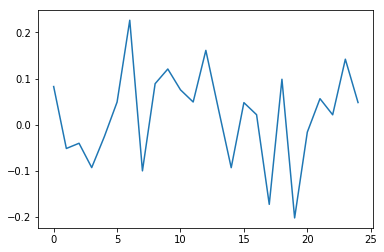

In [77]:
import matplotlib.pyplot as plt
plt.plot(portfolio_performance)

100